In [477]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *

In [478]:
def locallization(B):
    W = np.zeros([40,40])
    L=10
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

In [479]:
nT = 800
nk = 20
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)

# initial x_b: no values at the initial time (assign NaN)
x_b_save = np.array([x_a_init])

# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

B_temp_2 = B.copy()
B_a = np.reshape(B_temp_2,[40,40,1])
B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    # background
    if tt ==0:
        B = B.copy()
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))
        K = np.reshape(K_i, [1,40,40])
    else:
        k_i = np.split(K,ttf)[tt]
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        x_b = x_b_save[tt].transpose()
        # observation
        y_o = y_o_save[tt].transpose()
        #perturb observation
        np.random.seed(20191130+e)
        y_o_k = y_o + observation_error * np.random.randn(N)
        
        # innovation
        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        x_a = x_b + np.dot(K_i,d)
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            #print()
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        np.random.seed(20181130+e+2*tt)
        #print(x_a_k_save[tt].shape)
        solver = ode(lorenz96.f).set_integrator('dopri5')
        solver.set_initial_value(x_a.transpose() + 0.25 * np.random.randn(N), Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save,x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    #do the poll
    
    PH = np.cov(x_b_k_save,rowvar = False)
    HPH = np.cov(x_b_k_save,rowvar = False)
    
    #print(np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))
    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis =0)
    print(np.trace(PH))
    tt += 1

#save background and analysis data

x_b_save = x_b_save[0:801][:]
x_a_save = x_a_save[1:802][:]

np.savetxt('x_b_k20_l10_moedlerror0.25.txt', x_b_save)
np.savetxt('x_a_k20_l10_moedlerror0.25.txt', x_a_save)

x_a_save shape =  (1, 40)
Cycle = 0 , Ta = 0.0 , Tf = 0.05
2.8816801830853858
Cycle = 1 , Ta = 0.05 , Tf = 0.1
2.8998357765824245
Cycle = 2 , Ta = 0.1 , Tf = 0.15
2.685931722527727
Cycle = 3 , Ta = 0.15 , Tf = 0.2
2.7799198585633538
Cycle = 4 , Ta = 0.2 , Tf = 0.25
2.795656609319856
Cycle = 5 , Ta = 0.25 , Tf = 0.3
2.5305999832898083
Cycle = 6 , Ta = 0.3 , Tf = 0.35
2.6210966480065436
Cycle = 7 , Ta = 0.35 , Tf = 0.4
2.4161407182640846
Cycle = 8 , Ta = 0.4 , Tf = 0.45
2.615346223419935
Cycle = 9 , Ta = 0.45 , Tf = 0.5
2.6090750811553267
Cycle = 10 , Ta = 0.5 , Tf = 0.55
2.5200384151612387
Cycle = 11 , Ta = 0.55 , Tf = 0.6
2.604195724855956
Cycle = 12 , Ta = 0.6 , Tf = 0.65
2.6668978889105874
Cycle = 13 , Ta = 0.65 , Tf = 0.7
2.6205507393223
Cycle = 14 , Ta = 0.7 , Tf = 0.75
2.4871326174501203
Cycle = 15 , Ta = 0.75 , Tf = 0.8
2.6008554093878113
Cycle = 16 , Ta = 0.8 , Tf = 0.85
2.6560931419704437
Cycle = 17 , Ta = 0.85 , Tf = 0.9
2.5871149849894026
Cycle = 18 , Ta = 0.9 , Tf = 0.95
2.5

2.565387067978448
Cycle = 156 , Ta = 7.8 , Tf = 7.85
2.556039608768159
Cycle = 157 , Ta = 7.85 , Tf = 7.9
2.48416695335197
Cycle = 158 , Ta = 7.9 , Tf = 7.95
2.5008048943608654
Cycle = 159 , Ta = 7.95 , Tf = 8.0
2.514204728839354
Cycle = 160 , Ta = 8.0 , Tf = 8.05
2.6055089037962738
Cycle = 161 , Ta = 8.05 , Tf = 8.1
2.749366129169296
Cycle = 162 , Ta = 8.1 , Tf = 8.15
2.713125425791131
Cycle = 163 , Ta = 8.15 , Tf = 8.2
2.487705784726991
Cycle = 164 , Ta = 8.2 , Tf = 8.25
2.7043537685844545
Cycle = 165 , Ta = 8.25 , Tf = 8.3
2.7284277042742797
Cycle = 166 , Ta = 8.3 , Tf = 8.35
2.7468567826253816
Cycle = 167 , Ta = 8.35 , Tf = 8.4
2.725198916445715
Cycle = 168 , Ta = 8.4 , Tf = 8.45
2.6076020364442045
Cycle = 169 , Ta = 8.45 , Tf = 8.5
2.594269948979996
Cycle = 170 , Ta = 8.5 , Tf = 8.55
2.592754340702051
Cycle = 171 , Ta = 8.55 , Tf = 8.6
2.8668889110736187
Cycle = 172 , Ta = 8.6 , Tf = 8.65
2.6937825755727127
Cycle = 173 , Ta = 8.65 , Tf = 8.7
2.7856738044881637
Cycle = 174 , Ta = 8

2.9230620135391088
Cycle = 306 , Ta = 15.3 , Tf = 15.35
2.7849495773976853
Cycle = 307 , Ta = 15.35 , Tf = 15.4
2.7770196978719026
Cycle = 308 , Ta = 15.4 , Tf = 15.45
2.5939789902116863
Cycle = 309 , Ta = 15.45 , Tf = 15.5
2.510811698081686
Cycle = 310 , Ta = 15.5 , Tf = 15.55
2.6465176432355064
Cycle = 311 , Ta = 15.55 , Tf = 15.6
2.5575850535881983
Cycle = 312 , Ta = 15.6 , Tf = 15.65
2.5665023809365786
Cycle = 313 , Ta = 15.65 , Tf = 15.7
2.5968330152380013
Cycle = 314 , Ta = 15.7 , Tf = 15.75
2.503632123026785
Cycle = 315 , Ta = 15.75 , Tf = 15.8
2.5136161085186517
Cycle = 316 , Ta = 15.8 , Tf = 15.85
2.552899792142592
Cycle = 317 , Ta = 15.85 , Tf = 15.9
2.4751618767682975
Cycle = 318 , Ta = 15.9 , Tf = 15.95
2.3930862387733125
Cycle = 319 , Ta = 15.95 , Tf = 16.0
2.471150067418582
Cycle = 320 , Ta = 16.0 , Tf = 16.05
2.5986248490319603
Cycle = 321 , Ta = 16.05 , Tf = 16.1
2.6143620282061235
Cycle = 322 , Ta = 16.1 , Tf = 16.15
2.6546832078835445
Cycle = 323 , Ta = 16.15 , Tf = 1

2.605493731004815
Cycle = 455 , Ta = 22.75 , Tf = 22.8
2.497768095859525
Cycle = 456 , Ta = 22.8 , Tf = 22.85
2.6506379723684645
Cycle = 457 , Ta = 22.85 , Tf = 22.9
2.7389819291896873
Cycle = 458 , Ta = 22.9 , Tf = 22.95
2.6766023893958595
Cycle = 459 , Ta = 22.95 , Tf = 23.0
2.688269793516482
Cycle = 460 , Ta = 23.0 , Tf = 23.05
2.6925148446911087
Cycle = 461 , Ta = 23.05 , Tf = 23.1
2.6318150020845996
Cycle = 462 , Ta = 23.1 , Tf = 23.15
2.6103063437279186
Cycle = 463 , Ta = 23.15 , Tf = 23.2
2.6120273866477506
Cycle = 464 , Ta = 23.2 , Tf = 23.25
2.6325042353071137
Cycle = 465 , Ta = 23.25 , Tf = 23.3
2.4970965547543695
Cycle = 466 , Ta = 23.3 , Tf = 23.35
2.3521185165498326
Cycle = 467 , Ta = 23.35 , Tf = 23.4
2.4864239169481057
Cycle = 468 , Ta = 23.4 , Tf = 23.45
2.4350799270598555
Cycle = 469 , Ta = 23.45 , Tf = 23.5
2.3421628645719714
Cycle = 470 , Ta = 23.5 , Tf = 23.55
2.3598027633702854
Cycle = 471 , Ta = 23.55 , Tf = 23.6
2.50835677062556
Cycle = 472 , Ta = 23.6 , Tf = 23.

2.838554353912764
Cycle = 604 , Ta = 30.2 , Tf = 30.25
2.82008350705327
Cycle = 605 , Ta = 30.25 , Tf = 30.3
2.893406388558294
Cycle = 606 , Ta = 30.3 , Tf = 30.35
2.8440953866925445
Cycle = 607 , Ta = 30.35 , Tf = 30.4
2.6901001963295315
Cycle = 608 , Ta = 30.4 , Tf = 30.45
2.7107024302934133
Cycle = 609 , Ta = 30.45 , Tf = 30.5
2.6325743908806656
Cycle = 610 , Ta = 30.5 , Tf = 30.55
2.6540315655520996
Cycle = 611 , Ta = 30.55 , Tf = 30.6
2.5254207696202498
Cycle = 612 , Ta = 30.6 , Tf = 30.65
2.492419869064835
Cycle = 613 , Ta = 30.65 , Tf = 30.7
2.385838904558825
Cycle = 614 , Ta = 30.7 , Tf = 30.75
2.448978626411206
Cycle = 615 , Ta = 30.75 , Tf = 30.8
2.3671465113688197
Cycle = 616 , Ta = 30.8 , Tf = 30.85
2.37737686104693
Cycle = 617 , Ta = 30.85 , Tf = 30.9
2.5175488868995073
Cycle = 618 , Ta = 30.9 , Tf = 30.95
2.4407568855621995
Cycle = 619 , Ta = 30.95 , Tf = 31.0
2.432400606740881
Cycle = 620 , Ta = 31.0 , Tf = 31.05
2.508377339786369
Cycle = 621 , Ta = 31.05 , Tf = 31.1
2.6

Cycle = 751 , Ta = 37.55 , Tf = 37.6
2.7564805585285788
Cycle = 752 , Ta = 37.6 , Tf = 37.65
2.815316885553594
Cycle = 753 , Ta = 37.65 , Tf = 37.7
2.788259612301281
Cycle = 754 , Ta = 37.7 , Tf = 37.75
2.8036490371645977
Cycle = 755 , Ta = 37.75 , Tf = 37.8
2.7203456364373624
Cycle = 756 , Ta = 37.8 , Tf = 37.85
2.6629362444750617
Cycle = 757 , Ta = 37.85 , Tf = 37.9
2.456459927379714
Cycle = 758 , Ta = 37.9 , Tf = 37.95
2.5842954201298767
Cycle = 759 , Ta = 37.95 , Tf = 38.0
2.6666692050013894
Cycle = 760 , Ta = 38.0 , Tf = 38.05
2.7389080073795924
Cycle = 761 , Ta = 38.05 , Tf = 38.1
2.4763667263384415
Cycle = 762 , Ta = 38.1 , Tf = 38.15
2.428137751611379
Cycle = 763 , Ta = 38.15 , Tf = 38.2
2.5224544073263786
Cycle = 764 , Ta = 38.2 , Tf = 38.25
2.5229980296362826
Cycle = 765 , Ta = 38.25 , Tf = 38.3
2.549519510113364
Cycle = 766 , Ta = 38.3 , Tf = 38.35
2.5549639170728695
Cycle = 767 , Ta = 38.35 , Tf = 38.4
2.6550656541475597
Cycle = 768 , Ta = 38.4 , Tf = 38.45
2.61839954976883

In [480]:
bias_v = []
rmse_v = []
for i in range(N):
    pt = i
    #plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    #plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    #plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_b_save[:,pt-1]-x_t_save[:,pt-1]).mean()
    #print("bias = ", bias_i)
    rmse_i = np.std(x_b_save[:,pt-1]-x_t_save[:,pt-1])
    #print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    #plt.xlabel(r'$t$', size=18)
    #plt.ylabel(r'$x$', size=18)
    #plt.xlim(0,3)
    #plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    #plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    #plt.show()
    #plt.close()
print("bias=",np.mean(bias_v))
print("rmse=",np.mean(rmse))

bias= 0.009268295637166265
rmse= 0.18903909917474646


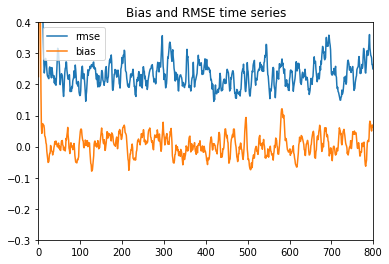

rmse= 0.23237335400662532
bias= 0.005248052507990646


In [481]:
analysis_error = x_b_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)


plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label ="bias")
plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)
np.savetxt('ENKF_k20_l10_moedlerror0.25_bias.txt',bias_t)
np.savetxt('ENKF_k20_l10_moedlerror0.25_rmse.txt',rmse_t)

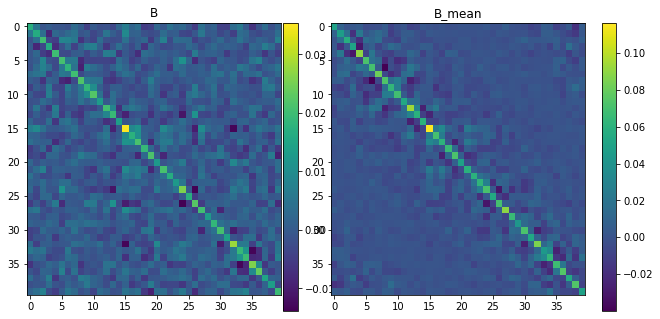

In [443]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.08, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(np.reshape(k_i,[40,40]))
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.08, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

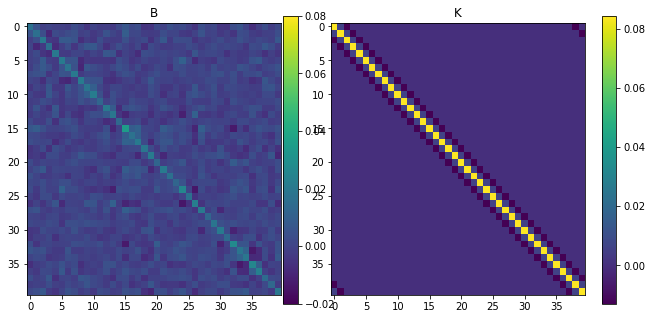

In [444]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH,vmin=-0.02,vmax=0.08)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

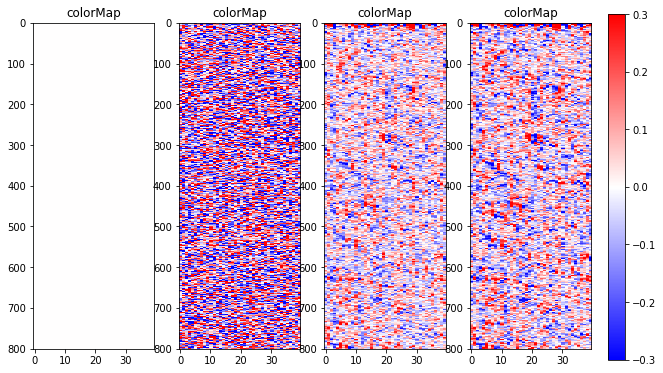

In [445]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('colorMap')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('colorMap')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('colorMap')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('colorMap')
plt.imshow(x_b_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [446]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(0, 40), ylim=(0, 40))

ax.set_title('B')
ax.set_aspect('auto')

#line, = ax.plot([], [], lw=2)
a = np.random.random((40,40))
im = plt.imshow(a,interpolation='none', vmin=-0.02, vmax =0.06)
# initialization function: plot the background of each frame
def init():
    im.set_data(np.random.random((40,40)))
           
    cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    return [im]

# animation function.  This is called sequentially
def animate(i):

    a = np.reshape(np.split(K,ttf+1)[i], [40,40])
    im.set_array(a)

    return [im]

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


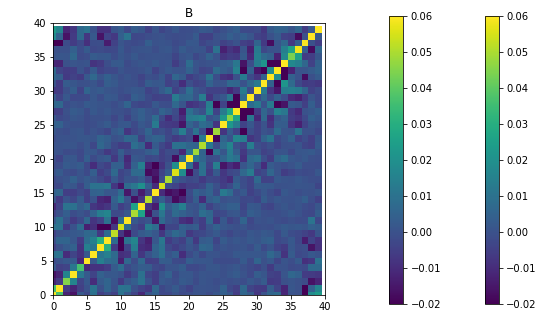

In [447]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=10, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])
plt.show()